<a href="https://colab.research.google.com/github/Jyotsna-krsna/GenAI-Course-Repo/blob/Assignments/Day1Assignment_Sentiment_Jyotsna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load (Import) the **Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import os

In [ ]:
# Download the dataset (https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/twitter_training.csv),  upload the csv file
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

# Unzip the downloaded file (the zip file has 2 files : twitter_training.csv & twitter_validation.csv)
!unzip twitter-entity-sentiment-analysis -d ./datasets

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 45.4MB/s]
Archive:  twitter-entity-sentiment-analysis.zip
  inflating: ./datasets/twitter_training.csv  
  inflating: ./datasets/twitter_validation.csv  


In [ ]:
# Load the dataset and add headers as there are missing headers
df = pd.read_csv('datasets/twitter_training.csv', names=['TwitterId','BorderID','Sentiment','Tweet'], header=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TwitterId  74681 non-null  int64 
 1   BorderID   74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
#Drop the TwitterId & BorderID columns as they are unneeded
df.drop(['TwitterId', 'BorderID'],axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  74681 non-null  object
 1   Tweet      73995 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
#check for null values
df.isna().sum()

Sentiment      0
Tweet        686
dtype: int64

In [ ]:
#drop the rows where Tweet is null(686 rows)
#we can also just use the required columns: df=df[['Sentiment','Tweet']]
df.dropna(subset=['Tweet'],axis=0,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  73995 non-null  object
 1   Tweet      73995 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [ ]:
df.shape

In [ ]:
# import the regular expression library to do the text pre-processing
import re
df['Tweet'] = df['Tweet'].apply(lambda x: x.lower())
df['Tweet'] = df['Tweet'].apply((lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  73995 non-null  object
 1   Tweet      73995 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [ ]:
df.head()

,Sentiment,Tweet
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [ ]:
print(df[df['Sentiment'] == 'Positive'].size)
print(df[df['Sentiment'] == 'Negative'].size)
print(df[df['Sentiment'] == 'Neutral'].size)
print(df[df['Sentiment'] == 'Irrelevant'].size)

41308
44716
36216
25750


In [ ]:
#convert 'Irrelevant sentiment to Neutral
df = df.replace('Irrelevant', 'Neutral')

In [ ]:
seq_length = [len(seq) for seq in X]
plt.hist(seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
vocab_size = tokenizer.num_words + 1
#seq_length = 166

tokenizer.fit_on_texts(df['Tweet'].values)
X = tokenizer.texts_to_sequences(df['Tweet'].values)
X = pad_sequences(X)


# Build RNN **Model**

In [ ]:
# Build the RNN model
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Activation
from sklearn.model_selection import train_test_split

embed_dim = 128

model = Sequential()
#model.add(Dense(units=64, input_shape=(32,)))

model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_length))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=False))
model.add(Dense(units=3, activation='softmax'))

#model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(seq_length,1)))
#model.add(SimpleRNN(units=50))
#model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])



In [ ]:
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape, ' ', y_train.shape)
print(X_test.shape, ' ', y_test.shape)

(49576, 166)   (49576, 3)
(24419, 166)   (24419, 3)


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Save the model
model.save('my_model.h5')






764/764 [==============================] - 19s 25ms/step - loss: 0.7887 - accuracy: 0.6461
Test Loss: [0.7886608242988586, 0.6461362242698669]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/my_model.h5')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Make predictions
predictions = model.predict(X_test)
scaler=MinMaxScaler()
#scaled_data=scaler.fit_transform(df[['Sentiment']])
#scaled_data=pd.DataFrame(scaled_data)

# Fit the scaler to the training data
scaler.fit(y_train)

# Make predictions
predictions = model.predict(X_test)

# Transform the predictions to match the shape of the training data
predictions = scaler.transform(predictions)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)



764/764 [==============================] - 20s 27ms/step


ValueError: x and y must have same first dimension, but have shapes (73995,) and (24419, 3)

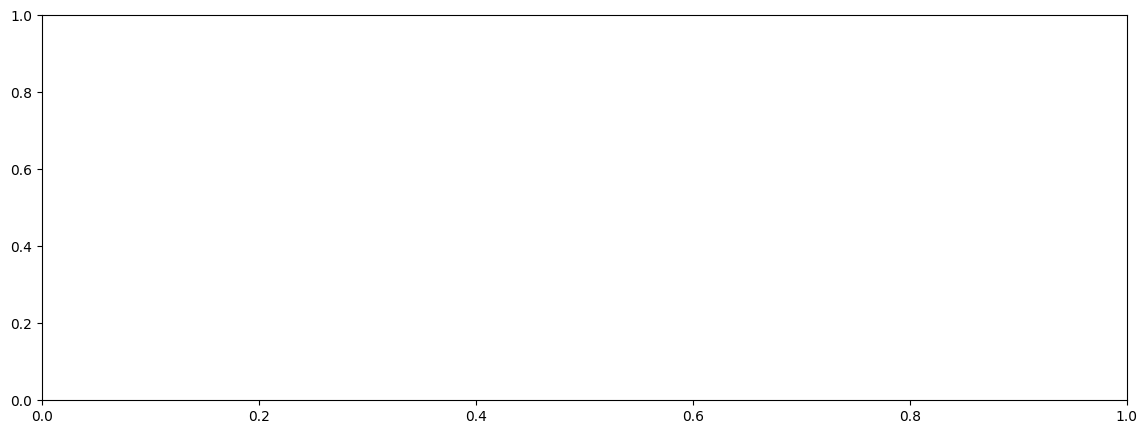

In [ ]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(range(len(df)), predictions, label='True Sentiment')
plt.plot(range(len(X_train) + seq_length, len(X_train) + seq_length + len(predictions)), predictions, label='Predicted Stock Price')
plt.xlabel('Tweet')
plt.ylabel('Sentiment')
plt.legend()
plt.show()

Find Sequence length

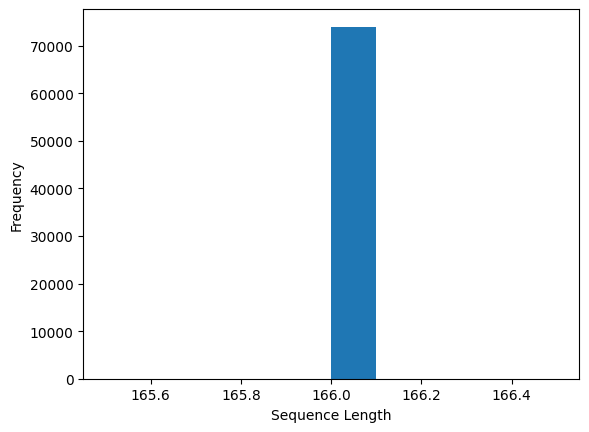

In [ ]:
sequence_lengths = [len(seq) for seq in X]
plt.hist(sequence_lengths)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

**Build LSTM Model**

In [ ]:
# Build the LSTM model
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Activation
from sklearn.model_selection import train_test_split

embed_dim = 128

model = Sequential()
#model.add(Dense(units=64, input_shape=(32,)))

model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_length))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=3, activation='softmax'))

#model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(seq_length,1)))
#model.add(SimpleRNN(units=50))
#model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

# GRU (Gated Recurrent *Unit* **bold text**)

In [ ]:
# Build the GRU model
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Activation
from sklearn.model_selection import train_test_split

embed_dim = 128

model = Sequential()
#model.add(Dense(units=64, input_shape=(32,)))

model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_length))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64, return_sequences=False))
model.add(Dense(units=3, activation='softmax'))

#model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(seq_length,1)))
#model.add(SimpleRNN(units=50))
#model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])